In [1]:
import os
import torch
import random
import numpy as np
import matplotlib.pyplot
from bh_utils import *

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

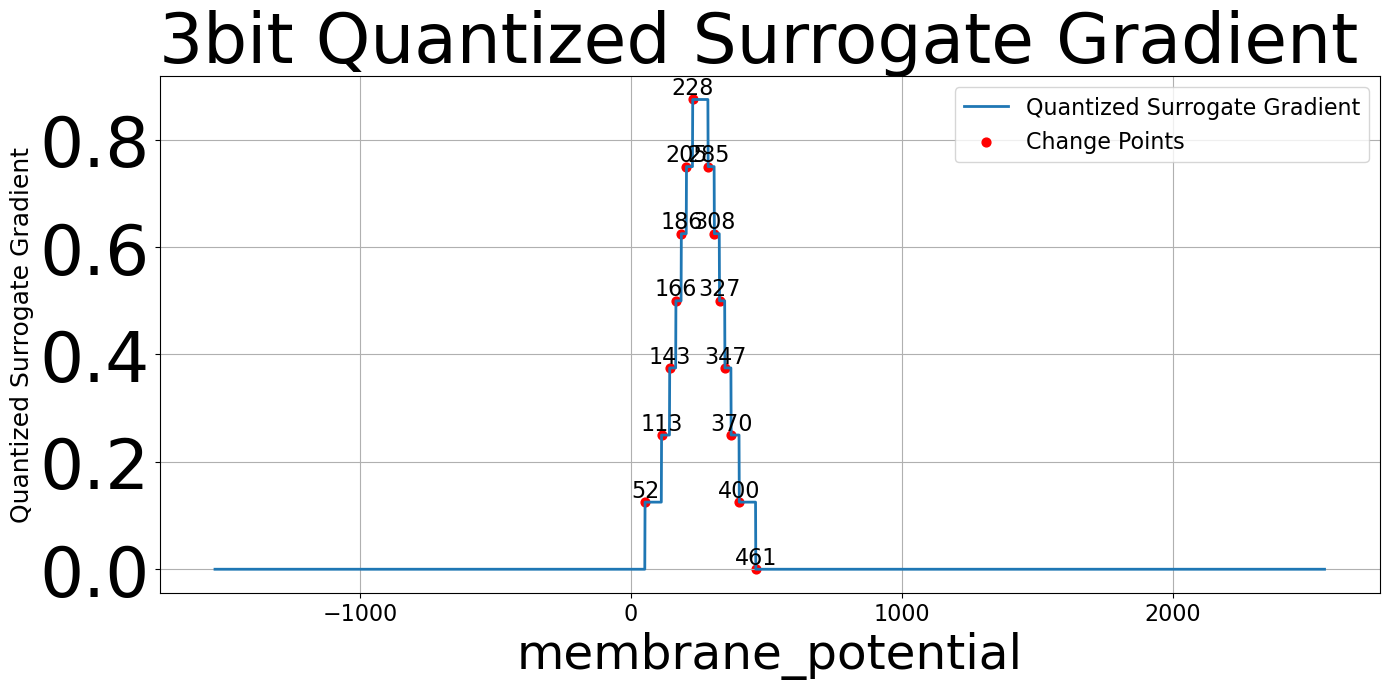

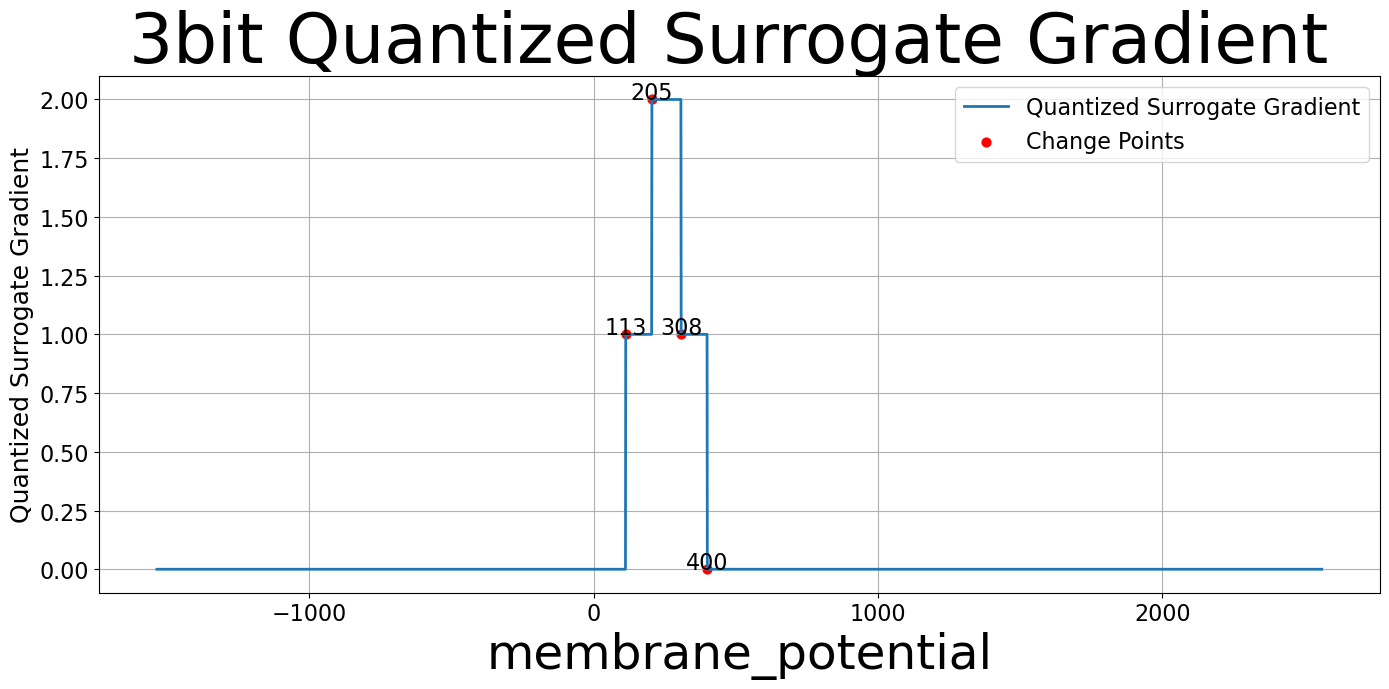

Original length: 4
Extended length: 14
Result: [113, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 308, 400]
x_change_before_lr: tensor([ 52., 113., 143., 166., 186., 205., 228., 285., 308., 327., 347., 370.,
        400., 461.])
x_change_after_lr: tensor([113., 205., 308., 400.])
x_change_after_lr_extension: [113, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 308, 400]
final_output: [256, 113, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 308, 400]


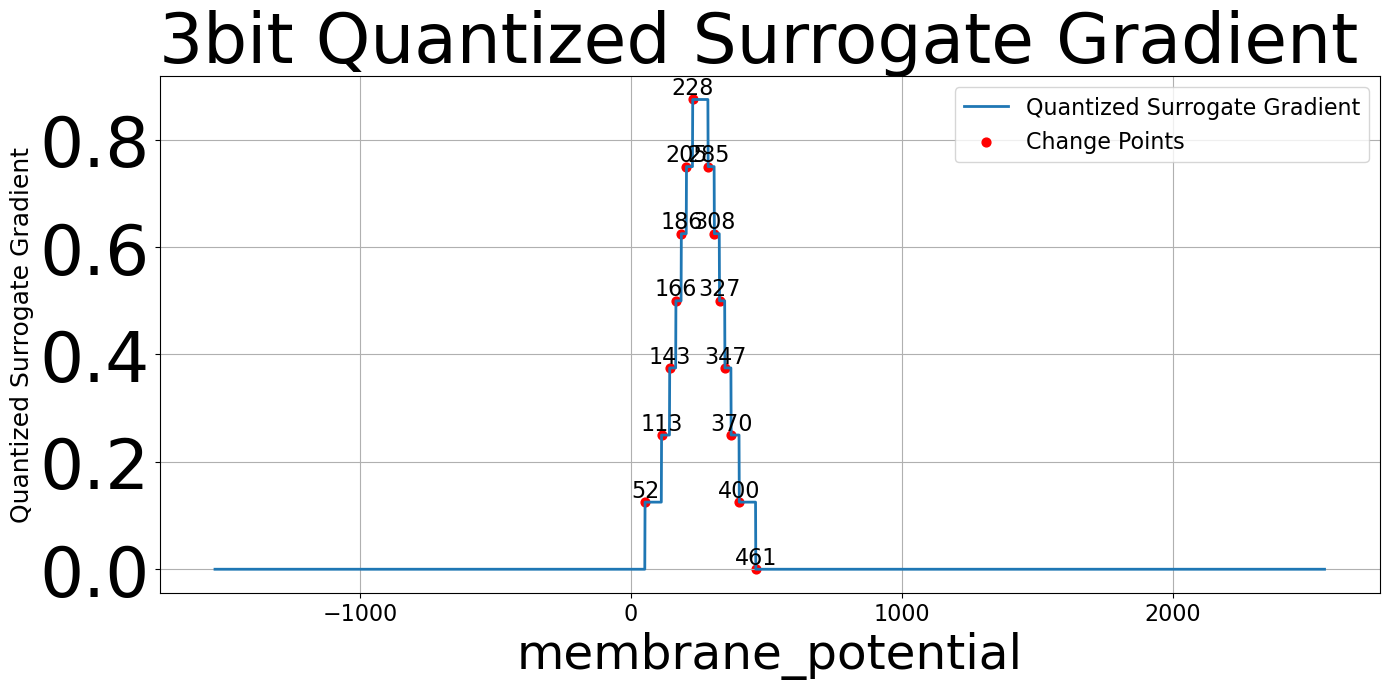

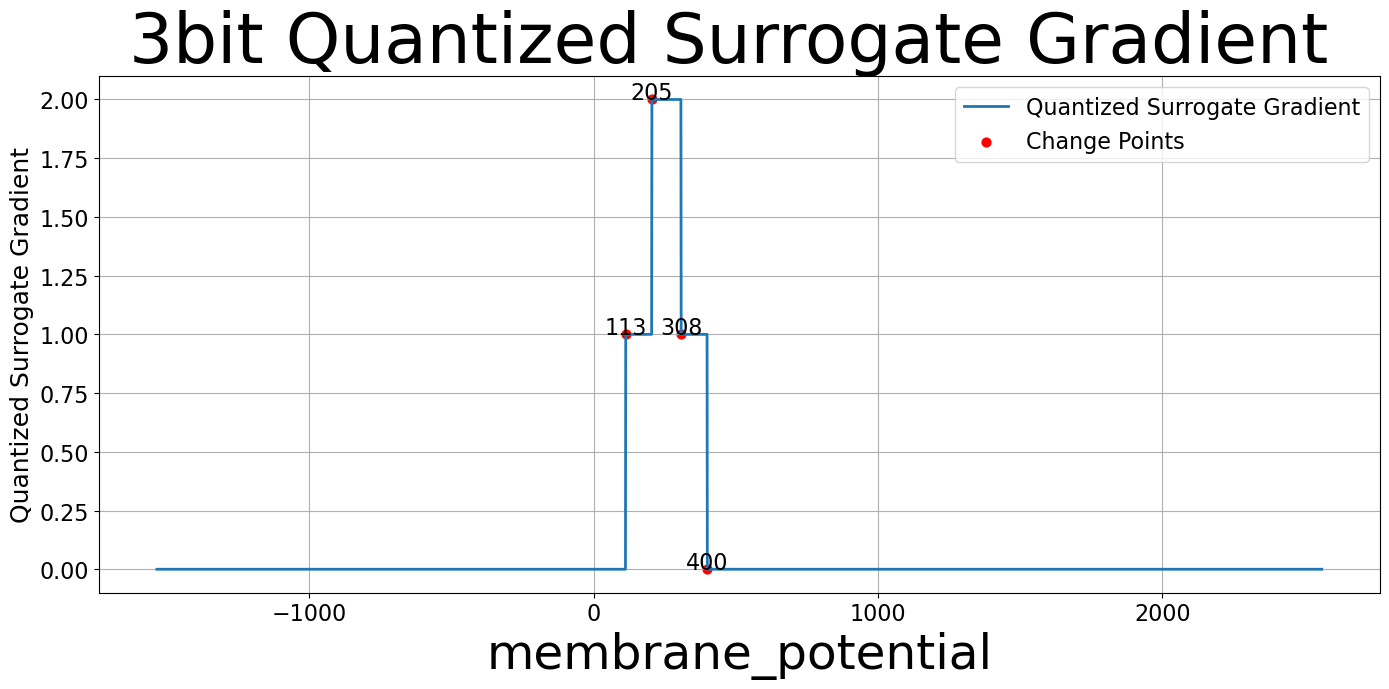

Original length: 4
Extended length: 14
Result: [113, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 308, 400]
x_change_before_lr: tensor([ 52., 113., 143., 166., 186., 205., 228., 285., 308., 327., 347., 370.,
        400., 461.])
x_change_after_lr: tensor([113., 205., 308., 400.])
x_change_after_lr_extension: [113, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 308, 400]
final_output: [256, 113, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 308, 400]
Start (MSB side): 00000000000000000000000000000000000000000000000000000000000000c3...
End (LSB side): ...000000000000000000000000bb1fbbbbbabc21ba0cbcbabcbababc37d11ae01c
✅ 파일 저장 완료: init_weight.txt
총 Hex 글자 수: 883,200자
파일 용량: 441,600B
파일 용량: 0.421MB


In [2]:
my_seed = 0
file_path = r"net_save\save_now_net_weights_20260112_121819_873.pth"
# file_path = None
p_config = { # Trigger는 다시 당겨지고..
    "asic_mode":                      {"trigger": 1,  "value": 0},   # 0 training_only, 1 train_inf_sweep, 2 inference_only
    "training_epochs":                {"trigger": 2,  "value": 200},
    "inference_epochs":               {"trigger": 3,  "value": 500},
    "dataset":                        {"trigger": 4,  "value": 2},   # 0 DVS_GESTURE, 1 N_MNIST, 2 NTIDIGITS
    "timesteps":                      {"trigger": 5,  "value": 5},
    "input_size_layer1":              {"trigger": 6,  "value": 578},
    "long_time_input_streaming_mode": {"trigger": 7,  "value": 0},
    "binary_classifier_mode":         {"trigger": 8,  "value": 0},
    "loser_encourage_mode":           {"trigger": 9,  "value": 0},
    "layer1_cut_list":                {"trigger": 10, "value": layer_cut_generator(threshold = 256, sg_width = 10.0 * 2, learning_rate = 2.0, verbose = True)},
    # "layer1_cut_list":                {"trigger": 10, "value": [256, 113, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 308, 400]},
    # "layer1_cut_list":                {"trigger": 10, "value": 옛날[256,17,171,342,342,342,342,342,342,342,342,342,342,342,496]},
    "layer2_cut_list":                {"trigger": 11, "value": layer_cut_generator(threshold = 256, sg_width = 10.0 * 2, learning_rate = 2.0, verbose = True)},
    # "layer2_cut_list":                {"trigger": 11, "value": [256, 113, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 308, 400]},
}


if p_config["dataset"]["value"] == 0:
    dataset = 'DVS_GESTURE' # 0 DVS_GESTURE, 1 N_MNIST, 2 NTIDIGITS
elif p_config["dataset"]["value"] == 1:
    dataset = 'N_MNIST'
elif p_config["dataset"]["value"] == 2:
    dataset = 'NTIDIGITS'
else:
    assert False, "데이터셋 설정 필요"




seed_assign(my_seed)
if dataset == 'DVS_GESTURE':
    input_size = 980
    init_scaling = [10000+ 9,10000+ 9,10000+ 8]
elif dataset == 'N_MNIST':
    input_size = 578
    init_scaling = [10000+ 9,10000+ 9,10000+ 8]
elif dataset == 'NTIDIGITS':
    input_size = 512
    init_scaling = [10000+ 12,10000+ 12,10000+ 11]
else:
    assert False, "데이터셋 설정 필요"  


layer1_sram_row = 980
layer1_sram_bank = 10
layer1_sram_bit = 160
layer2_sram_row = 200
layer2_sram_bank = 10
layer2_sram_bit = 160
layer3_sram_row = 200
layer3_sram_bank = 10
layer3_sram_bit = 8



if (file_path is not None) :
    if not os.path.exists(file_path):
        print("파일을 찾을 수 없습니다.")
    else:
        # 파일 로드
        # weights = torch.load(file_path, map_location=torch.device('cpu'))
        weights = torch.load(file_path, map_location=torch.device('cpu'), weights_only=True)
        # print(f"=== 'fc.weight' 필터링 결과 ===\n")
        # print(f"{'Layer Name':<40} | {'Shape'}")
        # print("-" * 60)

        if isinstance(weights, dict):
            for key, value in weights.items():
                if "module.layers.1.fc.weight" in key:
                    # weight_plot(value)
                    if dataset == 'DVS_GESTURE':
                        assert value.shape == (200,980), f"value.shape: {value.shape}"
                    elif dataset == 'N_MNIST':
                        assert value.shape == (200,578), f"value.shape: {value.shape}"
                    elif dataset == 'NTIDIGITS':
                        assert value.shape == (200,512), f"value.shape: {value.shape}"
                    else:
                        assert False, "데이터셋 설정 필요"  

                    layer1_weight = torch.nn.functional.pad(value, (0, layer1_sram_row - value.shape[1], 0, 0), "constant", 0)
                    # print(f"{key:<40} | {list(layer1_weight.shape)}")
                    # print(layer1_weight)
                if "module.layers.4.fc.weight" in key:
                    assert value.shape == (200,200), f"value.shape: {value.shape}"
                    # weight_plot(value)
                    layer2_weight = value
                    # print(f"{key:<40} | {list(layer2_weight.shape)}")
                    # print(layer2_weight)
                if "module.layers.7.fc.weight" in key:
                    assert value.shape == (10,200), f"value.shape: {value.shape}"
                    # weight_plot(value)
                    layer3_weight = value
                    # print(f"{key:<40} | {list(layer3_weight.shape)}")
                    # print(layer3_weight)
        else:
            print("딕셔너리 형태가 아닙니다.")


else:
    layer1_value = torch.nn.Linear(input_size, layer2_sram_row, bias=False)
    layer1_weight = layer1_value.weight.data * (2**(init_scaling[0]-10000) * 1.0) if init_scaling[0] >= 10000 else layer1_value.weight.data * (2**(init_scaling[0]) * 1.0)
    layer1_weight = quantize_tensor(layer1_weight)
    # weight_plot(layer1_weight)
    layer1_weight = torch.nn.functional.pad(layer1_weight, (0, layer1_sram_row - layer1_weight.shape[1], 0, 0), "constant", 0)
    # print(layer1_weight, layer1_weight.shape)


    layer2_value = torch.nn.Linear(layer2_sram_row, layer3_sram_row, bias=False)
    layer2_weight = layer2_value.weight.data * (2**(init_scaling[1]-10000) * 1.0) if init_scaling[0] >= 10000 else layer1_value.weight.data * (2**(init_scaling[0]) * 1.0)
    layer2_weight = quantize_tensor(layer2_weight)
    # weight_plot(layer2_weight)
    # print(layer2_weight, layer2_weight.shape)


    layer3_value = torch.nn.Linear(layer3_sram_row, 10, bias=False)
    layer3_weight = layer3_value.weight.data * (2**(init_scaling[2]-10000) * 1.0) if init_scaling[0] >= 10000 else layer1_value.weight.data * (2**(init_scaling[0]) * 1.0)
    layer3_weight = quantize_tensor(layer3_weight)
    # weight_plot(layer3_weight)
    # print(layer3_weight, layer3_weight.shape)

layer1_weight_np = layer1_weight.numpy().astype(np.int8)
layer2_weight_np = layer2_weight.numpy().astype(np.int8)
layer3_weight_np = layer3_weight.numpy().astype(np.int8)


layer1_weight_np_t = layer1_weight_np.T

# 세로(axis=1) 방향으로 10등분
# 200열 / 10개 뱅크 = 각 뱅크당 20열
layer1_banks = np.split(layer1_weight_np_t, layer1_sram_bank, axis=1)
layer1_banks_renewal = np.split(layer1_weight_np_t.copy(), layer1_sram_bank, axis=1)
for i in range(layer1_banks[0].shape[0]):
    for j in range(len(layer1_banks)):
        idx1 = (j + (i%10))%10
        (layer1_banks_renewal[idx1])[i] = (layer1_banks[j])[i]

# axis=1(열 방향)로 10개의 뱅크를 다시 이어붙임
layer1_weight_reassembled = np.concatenate(layer1_banks_renewal, axis=1) # (980, 200)



layer2_weight_np_t = layer2_weight_np.T

layer2_banks = np.split(layer2_weight_np_t, layer2_sram_bank, axis=1)
layer2_banks_renewal = np.split(layer2_weight_np_t.copy(), layer2_sram_bank, axis=1)
for i in range(layer2_banks[0].shape[0]):
    for j in range(len(layer2_banks)):
        idx1 = (j + (i%10))%10
        (layer2_banks_renewal[idx1])[i] = (layer2_banks[j])[i]

layer2_weight_reassembled = np.concatenate(layer2_banks_renewal, axis=1) 


layer3_weight_np_t = layer3_weight_np.T

layer3_banks = np.split(layer3_weight_np_t, layer3_sram_bank, axis=1)
layer3_banks_renewal = np.split(layer3_weight_np_t.copy(), layer3_sram_bank, axis=1)
for i in range(layer3_banks[0].shape[0]):
    for j in range(len(layer3_banks)):
        idx1 = (j + (i%10))%10
        (layer3_banks_renewal[idx1])[i] = (layer3_banks[j])[i]

layer3_weight_reassembled = np.concatenate(layer3_banks_renewal, axis=1) 

# print(f'layer1_weight_reassembled shape: {layer1_weight_reassembled.shape}')
# print(f'layer2_weight_reassembled shape: {layer2_weight_reassembled.shape}')
# print(f'layer3_weight_reassembled shape: {layer3_weight_reassembled.shape}')


# 결과를 저장할 리스트 (또는 파일로 직접 저장 가능)
layer1_hex_outputs = []
for row in range(layer1_weight_reassembled.shape[0]):
    for bank in range(layer1_sram_bank):
        # 1. 현재 뱅크의 20바이트 추출
        one_dram_word = layer1_weight_reassembled[row, bank*20 : (bank+1)*20]
        
        # 2. 역순 정렬: [19][18]...[0] 순서로 hex 문자열 생성
        # 각 요소는 8bit이므로 2자리 hex(:02x)로 변환
        hex_160bit = "".join(f"{int(val) & 0xFF:02x}" for val in reversed(one_dram_word))
        
        # 3. 256bit가 되도록 상위에 96bit(hex 24자리) 0 패딩 추가
        # 256bit = 64 hex chars (160bit = 40 hex chars)
        padding_96bit = "0" * 24
        final_256bit_word = padding_96bit + hex_160bit
        
        layer1_hex_outputs.append(final_256bit_word)
    
# 결과를 저장할 리스트 (또는 파일로 직접 저장 가능)
layer2_hex_outputs = []
for row in range(layer2_weight_reassembled.shape[0]):
    for bank in range(layer2_sram_bank):
        # 1. 현재 뱅크의 20바이트 추출
        one_dram_word = layer2_weight_reassembled[row, bank*20 : (bank+1)*20]
        
        # 2. 역순 정렬: [19][18]...[0] 순서로 hex 문자열 생성
        # 각 요소는 8bit이므로 2자리 hex(:02x)로 변환
        hex_160bit = "".join(f"{int(val) & 0xFF:02x}" for val in reversed(one_dram_word))
        
        # 3. 256bit가 되도록 상위에 96bit(hex 24자리) 0 패딩 추가
        # 256bit = 64 hex chars (160bit = 40 hex chars)
        padding_96bit = "0" * 24
        final_256bit_word = padding_96bit + hex_160bit
        
        layer2_hex_outputs.append(final_256bit_word)
    
# 결과를 저장할 리스트 (또는 파일로 직접 저장 가능)
layer3_hex_outputs = []
for row in range(layer3_weight_reassembled.shape[0]):
    for bank in range(layer3_sram_bank):
        # 1. 현재 뱅크의 1바이트 추출
        one_dram_word = layer3_weight_reassembled[row, bank*1 : (bank+1)*1]
        
        # 2. 역순 정렬: [19][18]...[0] 순서로 hex 문자열 생성
        # 각 요소는 8bit이므로 2자리 hex(:02x)로 변환
        hex_8bit = "".join(f"{int(val) & 0xFF:02x}" for val in reversed(one_dram_word))
        
        # 3. 256bit가 되도록 상위에 248bit(hex 62자리) 0 패딩 추가
        # 256bit = 64 hex chars (248bit = 62 hex chars)
        padding_248bit = "0" * 62
        final_256bit_word = padding_248bit + hex_8bit
        
        layer3_hex_outputs.append(final_256bit_word)
# print(f'layer1_hex_outputs length: {len(layer1_hex_outputs)}')
# print(f'layer2_hex_outputs length: {len(layer2_hex_outputs)}')
# print(f'layer3_hex_outputs length: {len(layer3_hex_outputs)}')

total_hex_outputs = layer1_hex_outputs + layer2_hex_outputs + layer3_hex_outputs
# print(f'total_hex_outputs length: {len(total_hex_outputs)}')


# total_hex_outputs의 요소들을 역순으로 뒤집어서(reversed) 하나로 합칩니다.
# 결과물은 엄청나게 긴 하나의 Hex 문자열이 됩니다.
total_long_hex_string = "".join(reversed(total_hex_outputs))

# # 출력 확인 (너무 길 수 있으니 앞뒤 일부와 전체 길이만 확인)
# print(f"Total String Length (Hex chars): {len(total_long_hex_string)}")
# print(f"Total String Length (Bits): {len(total_long_hex_string) * 4}bit")
# print(f"Total String Length (Bytes): {len(total_long_hex_string) * 4 / 8:.3f}Byte")
# print(f"Total String Length (kBytes): {len(total_long_hex_string) * 4 / 8/ 1024:.3f}kByte")
# print(f"Total String Length (MBytes): {len(total_long_hex_string) * 4 / 8/ 1024/1024:.3f}MByte")
# print(f'DRAM Address Range: 0 to {len(total_long_hex_string) * 4 / 256 *8 - 8:.0f}')
print(f"Start (MSB side): {total_long_hex_string[:64]}...")
print(f"End (LSB side): ...{total_long_hex_string[-64:]}")

# total_long_hex_string을 하나의 긴 문자열로 그대로 저장합니다.
with open("init_weight.txt", "w") as f:
    f.write(total_long_hex_string)

print(f"✅ 파일 저장 완료: init_weight.txt")
print(f"총 Hex 글자 수: {len(total_long_hex_string):,}자")
print(f"파일 용량: {len(total_long_hex_string) / 2:,.0f}B")
print(f"파일 용량: {len(total_long_hex_string) / 2 / 1024 / 1024:.3f}MB")

# # # 1. 파일 다시 읽기
# with open("init_weight.txt", "r") as f:
#     loaded_hex_string = f.read()

# # 2. 원본 데이터와 비교
# is_identical = (total_long_hex_string == loaded_hex_string)

# # 3. 결과 출력
# print(f"=== 검증 결과 ===")
# print(f"원본 문자열 길이: {len(total_long_hex_string):,} 자")
# print(f"읽어온 문자열 길이: {len(loaded_hex_string):,} 자")
# print(f"데이터 일치 여부: {is_identical}")

# # 만약 다르다면 어느 부분이 다른지 체크 (데이터가 같으면 실행 안 됨)
# if not is_identical:
#     for i in range(min(len(total_long_hex_string), len(loaded_hex_string))):
#         if total_long_hex_string[i] != loaded_hex_string[i]:
#             print(f"최초로 다른 지점: 인덱스 {i}")
#             print(f"원본: {total_long_hex_string[i:i+10]}...")
#             print(f"파일: {loaded_hex_string[i:i+10]}...")
#             break

In [3]:
import time
import numpy as np
from mms_ok import XEM7310
from secrets import token_hex
import torch
import random
from bh_utils import *


bitstream_path = r"bitstream/top_bh_fpga.bit"
fpga = XEM7310(bitstream_path=bitstream_path)

def bh_btpipein(data, block_size_candidate = [16384, 64], verbose = False):
    total_start = time.time()

    left_string_len = len(data)
    read_string_len = 0

    for bl_size in block_size_candidate:
        if (left_string_len >= bl_size*2):
            read_string_len_temp = (left_string_len // (bl_size*2)) * (bl_size*2)
            sent_bytes = read_string_len_temp // 2
            
            # --- 각 블록 전송 시간 및 속도 측정 ---
            step_start = time.time()
            
            fpga.WriteToBlockPipeIn(0x80, data[read_string_len : read_string_len + read_string_len_temp], block_size=bl_size, reorder_str=True)
            
            step_end = time.time()
            duration = step_end - step_start
            
            # MiB/s 계산 (bytes / 1024^2 / sec)
            speed = (sent_bytes / (1024 * 1024)) / duration if duration > 0 else 0

            if (verbose):
                print(f"{bl_size:10d} byte | {duration*1000:10.4f} ms | {speed:12.2f} MiB/s | {sent_bytes:12d} bytes")

            left_string_len -= read_string_len_temp
            read_string_len += read_string_len_temp

    total_end = time.time()
    assert left_string_len == 0 and read_string_len == len(data)
    if (verbose):
        print("-" * 30)
        print(f"Total Time: {total_end - total_start:.4f} sec")
        print(f"Total Bytes: {read_string_len//2} bytes")


# ######### Reset ######################################################################
reset_time = 1.0  # seconds
print(f'Resetting FPGA for {reset_time} seconds...')
fpga.reset(reset_address = 0x00, reset_time = reset_time, active_low = True)
print('System reset complete.')
time.sleep(1.0) # 이거 꼭 해라
fpga.CheckTriggered(0x60, 1, timeout=10.0) # config 다됐냐
# ######### Reset ######################################################################

print('')
print('')
print('')
print('')

# fpga.SetWireInValue(0x01, signed_encoding_32bit(0))
# ep20wireout = signed_decoding_32bit(fpga.GetWireOutValue(0x20))
# print(f'WireOut 0x20 value: {ep20wireout}')
# ep21wireout = signed_decoding_32bit(fpga.GetWireOutValue(0x21))
# print(f'WireOut 0x21 value: {ep21wireout}')

# ######### p_config mode ######################################################################
p_config_ongoing_sleep_time = 0.01  # seconds
p_config_verbose = False
# config mode on
print(f'######### P_STATE_01_WORKLOAD_CONFIG mode ######################################################################')
fpga.SetWireInValue(0x01, signed_encoding_32bit(1))
fpga.ActivateTriggerIn(0x40, 0)
fpga.SetWireInValue(0x01, signed_encoding_32bit(0))
ep20wireout = signed_decoding_32bit(fpga.GetWireOutValue(0x20))
# asic_mode: 0 training_only, 1 train_inf_sweep, 2 inference_only 
fpga.SetWireInValue(0x01, signed_encoding_32bit(p_config['asic_mode']['value']))
fpga.ActivateTriggerIn(0x40, p_config['asic_mode']['trigger'])
fpga.SetWireInValue(0x01, signed_encoding_32bit(p_config['asic_mode']['trigger']))
ep20wireout = signed_decoding_32bit(fpga.GetWireOutValue(0x20))
if p_config_verbose:
    print(f'WireOut 0x20 value: {ep20wireout} <-- asic_mode')
time.sleep(p_config_ongoing_sleep_time)
# training_epochs
fpga.SetWireInValue(0x01, signed_encoding_32bit(p_config['training_epochs']['value']))
fpga.ActivateTriggerIn(0x40, p_config['training_epochs']['trigger'])
fpga.SetWireInValue(0x01, signed_encoding_32bit(p_config['training_epochs']['trigger']))
ep20wireout = signed_decoding_32bit(fpga.GetWireOutValue(0x20))
if p_config_verbose:
    print(f'WireOut 0x20 value: {ep20wireout} <-- training_epochs')
time.sleep(p_config_ongoing_sleep_time)
# inference_epochs
fpga.SetWireInValue(0x01, signed_encoding_32bit(p_config['inference_epochs']['value']))
fpga.ActivateTriggerIn(0x40, p_config['inference_epochs']['trigger'])
fpga.SetWireInValue(0x01, signed_encoding_32bit(p_config['inference_epochs']['trigger']))
ep20wireout = signed_decoding_32bit(fpga.GetWireOutValue(0x20))
if p_config_verbose:
    print(f'WireOut 0x20 value: {ep20wireout} <-- inference_epochs')
time.sleep(p_config_ongoing_sleep_time)
# dataset: 0 DVS_GESTURE, 1 N_MNIST, 2 NTIDIGITS
fpga.SetWireInValue(0x01, signed_encoding_32bit(p_config['dataset']['value']))
fpga.ActivateTriggerIn(0x40, p_config['dataset']['trigger'])
fpga.SetWireInValue(0x01, signed_encoding_32bit(p_config['dataset']['trigger']))
ep20wireout = signed_decoding_32bit(fpga.GetWireOutValue(0x20))
if p_config_verbose:
    print(f'WireOut 0x20 value: {ep20wireout} <-- dataset')
time.sleep(p_config_ongoing_sleep_time)
# timesteps
fpga.SetWireInValue(0x01, signed_encoding_32bit(p_config['timesteps']['value']))
fpga.ActivateTriggerIn(0x40, p_config['timesteps']['trigger'])
fpga.SetWireInValue(0x01, signed_encoding_32bit(p_config['timesteps']['trigger']))
ep20wireout = signed_decoding_32bit(fpga.GetWireOutValue(0x20))
if p_config_verbose:
    print(f'WireOut 0x20 value: {ep20wireout} <-- timesteps')
time.sleep(p_config_ongoing_sleep_time)
# input_size_layer1_define
fpga.SetWireInValue(0x01, signed_encoding_32bit(p_config['input_size_layer1']['value']))
fpga.ActivateTriggerIn(0x40, p_config['input_size_layer1']['trigger'])
fpga.SetWireInValue(0x01, signed_encoding_32bit(p_config['input_size_layer1']['trigger']))
ep20wireout = signed_decoding_32bit(fpga.GetWireOutValue(0x20))
if p_config_verbose:
    print(f'WireOut 0x20 value: {ep20wireout} <-- input_size_layer1')
time.sleep(p_config_ongoing_sleep_time)
# long_time_input_streaming_mode
fpga.SetWireInValue(0x01, signed_encoding_32bit(p_config['long_time_input_streaming_mode']['value']))
fpga.ActivateTriggerIn(0x40, p_config['long_time_input_streaming_mode']['trigger'])
fpga.SetWireInValue(0x01, signed_encoding_32bit(p_config['long_time_input_streaming_mode']['trigger']))
ep20wireout = signed_decoding_32bit(fpga.GetWireOutValue(0x20))
if p_config_verbose:
    print(f'WireOut 0x20 value: {ep20wireout} <-- long_time_input_streaming_mode')
time.sleep(p_config_ongoing_sleep_time)
# binary_classifier_mode
fpga.SetWireInValue(0x01, signed_encoding_32bit(p_config['binary_classifier_mode']['value']))
fpga.ActivateTriggerIn(0x40, p_config['binary_classifier_mode']['trigger'])
fpga.SetWireInValue(0x01, signed_encoding_32bit(p_config['binary_classifier_mode']['trigger']))
ep20wireout = signed_decoding_32bit(fpga.GetWireOutValue(0x20))
if p_config_verbose:
    print(f'WireOut 0x20 value: {ep20wireout} <-- binary_classifier_mode')
time.sleep(p_config_ongoing_sleep_time)
# loser_encourage_mode
fpga.SetWireInValue(0x01, signed_encoding_32bit(p_config['loser_encourage_mode']['value']))
fpga.ActivateTriggerIn(0x40, p_config['loser_encourage_mode']['trigger'])
fpga.SetWireInValue(0x01, signed_encoding_32bit(p_config['loser_encourage_mode']['trigger']))
ep20wireout = signed_decoding_32bit(fpga.GetWireOutValue(0x20))
if p_config_verbose:
    print(f'WireOut 0x20 value: {ep20wireout} <-- loser_encourage_mode')
time.sleep(p_config_ongoing_sleep_time)
# layer1_cut_list
for i in range(15):
    fpga.SetWireInValue(0x01, signed_encoding_32bit(p_config['layer1_cut_list']['value'][i]))
    fpga.ActivateTriggerIn(0x40, p_config['layer1_cut_list']['trigger'])
    fpga.SetWireInValue(0x01, signed_encoding_32bit(p_config['layer1_cut_list']['trigger']))
    time.sleep(p_config_ongoing_sleep_time)
    ep20wireout = signed_decoding_32bit(fpga.GetWireOutValue(0x20))
    if p_config_verbose:
        print(f'WireOut 0x20 value: {ep20wireout} <-- layer1_cut_list[{i}]')
# layer2_cut_list
for i in range(15):
    fpga.SetWireInValue(0x01, signed_encoding_32bit(p_config['layer2_cut_list']['value'][i]))
    fpga.ActivateTriggerIn(0x40, p_config['layer2_cut_list']['trigger'])
    fpga.SetWireInValue(0x01, signed_encoding_32bit(p_config['layer2_cut_list']['trigger']))
    time.sleep(p_config_ongoing_sleep_time)
    ep20wireout = signed_decoding_32bit(fpga.GetWireOutValue(0x20))
    if p_config_verbose:
        print(f'WireOut 0x20 value: {ep20wireout} <-- layer2_cut_list[{i}]')
# ######### p_config mode######################################################################
        
fpga.SetWireInValue(0x01, signed_encoding_32bit(0))

fpga.ActivateTriggerIn(0x40, 31)

fpga.CheckTriggered(0x60, 1, timeout=10.0) # config 다됐냐




    
print('')
print('')
print('')
print('')

# ######### p_config done mode ######################################################################
print(f'######### P_STATE_02_WORKLOAD_CONFIG_DONE mode ######################################################################')
fpga.SetWireInValue(0x01, signed_encoding_32bit(2))
fpga.ActivateTriggerIn(0x40, 0)
fpga.SetWireInValue(0x01, signed_encoding_32bit(0))
# ######### p_config done mode ######################################################################


    
print('')
print('')
print('')
print('')



# ######### P_STATE_03_DRAMFILL_WEIGHT_DATA mode ######################################################################
print(f'######### P_STATE_03_DRAMFILL_WEIGHT_DATA mode ######################################################################')
fpga.SetWireInValue(0x01, signed_encoding_32bit(3))
fpga.ActivateTriggerIn(0x40, 0)
fpga.SetWireInValue(0x01, signed_encoding_32bit(0))


# fpga.SetWireInValue(0x01, signed_encoding_32bit(8)) # dram write address
fpga.SetWireInValue(0x01, signed_encoding_32bit(0)) # dram write address
fpga.ActivateTriggerIn(0x40, 30)
# fpga.SetWireInValue(0x01, signed_encoding_32bit(16)) # dram write address last
fpga.SetWireInValue(0x01, signed_encoding_32bit(110392)) # dram write address last
fpga.ActivateTriggerIn(0x40, 30)
fpga.SetWireInValue(0x01, signed_encoding_32bit(0))
fpga.CheckTriggered(0x60, 1, timeout=10.0) # config 다됐냐


with open("init_weight.txt", "r") as f:
    loaded_hex_string = f.read()

# data = token_hex(32) # byte
# data = token_hex(64) # byte
# data = bytes(range(1, 65)).hex()
# data = "11" * 32 + "22" * 32 # 이거보니까 string 앞에 있는 게 먼저 들어가고. 
# data = "11" * 16 + "22" * 16 + "33" * 16 +"44" * 16 # 이거보니까 string 앞에 있는 게 먼저 들어가고. 
# data = "11" * 16 + "22" * 16 + "33" * 16 +"44" * 16 # 이거보니까 string 앞에 있는 게 먼저 들어가고. 
# data = "11"*8 + "22"*8 + "33"*8 + "44"*8 + "55"*8 + "66"*8 + "77"*8 + "88"*8
# data = "01"*4 + "02"*4 + "03"*4 + "04"*4 + "05"*4 + "06"*4 + "07"*4 + "08"*4 + "09"*4 + "0A"*4 + "0B"*4 + "0C"*4 + "0D"*4 + "0E"*4 + "0F"*4 + "10"*4
# data = "11" * 2 + 
# data = "11" * 1 + 
    

# data = "01"*4 + "02"*4 + "03"*4 + "04"*4 + "05"*4 + "06"*4 + "07"*4 + "08"*4 + "09"*4 + "0A"*4 + "0B"*4 + "0C"*4 + "0D"*4 + "0E"*4 + "0F"*4 + "10"*4
data = loaded_hex_string








# print(f'datain string length: {len(data)}') # 883200 (883200*2 byte)

# # block size (byte)  (len(data)*2) 가 아래숫자에 배수여야함.
# # USB 2.0 FullSpeed - Multiple of two [2..64]
# # USB 2.0 HighSpeed - Multiple of two [2..1024]
# # USB 3.0 FullSpeed - Power of two [16..64]
# # USB 3.0 HighSpeed - Power of two [16..1024]
# # USB 3.0 SuperSpeed - Power of two [16..16384]
# block_size_candidate = [16384, 8192, 4096, 2048, 1024, 512, 256, 128, 64, 32, 16]
# block_size_candidate = [16384, 16]
# block_size_candidate = [16384, 32]
# block_size_candidate = [16384, 64]
# block_size_candidate = [16]
# verbose = True
# bh_btpipein(data, block_size_candidate = [16384, 64], verbose = True) # block_size_candidate should be >= 64 and 2의 승수.

bh_btpipein(data) # block_size_candidate should be >= 64 and 2의 승수.



fpga.CheckTriggered(0x60, 1, timeout=1.0) # config 다됐냐
# ######### P_STATE_03_DRAMFILL_WEIGHT_DATA mode ######################################################################

print('')
print('')
print('')
print('')


print(f'######### P_STATE_04_DRAMFILL_WEIGHT_DATA_DONE mode ######################################################################')

# ######### P_STATE_04_DRAMFILL_WEIGHT_DATA_DONE mode ######################################################################
# fpga.SetWireInValue(0x01, signed_encoding_32bit(1))
# fpga.SetWireInValue(0x01, signed_encoding_32bit(0))
# ######### P_STATE_04_DRAMFILL_WEIGHT_DATA_DONE mode ######################################################################







2026-01-13 23:24:48.779 | INFO     | mms_ok.ok_setup:copy_frontpanel_files:28 - FrontPanel SDK Version: 5.3.6
2026-01-13 23:24:48.782 | INFO     | mms_ok.ok_setup:copy_frontpanel_files:39 - FrontPanel API ready


2026-01-13 23:24:48.975 | INFO     | mms_ok.fpga:_validate_bitstream_path:117 - Bitstream file: c:\Users\User\measurement_setting\bitstream\top_bh_fpga.bit
2026-01-13 23:24:48.976 | INFO     | mms_ok.fpga:_validate_bitstream_path:120 - Bitstream date: 2026-01-13 20:45:45
2026-01-13 23:24:48.987 | CRITICAL | mms_ok.fpga:_connect:138 - Device is not opened!


ConnectionError: Device is not opened!

In [ ]:
# fpga.SetWireInValue(0x01, signed_encoding_32bit(0))


In [ ]:
# # fpga.SetWireInValue(0x01, signed_encoding_32bit(p_config['layer2_cut_list']['trigger']))
# fpga.SetWireInValue(0x01, 0)

# ep20wireout = signed_decoding_32bit(fpga.GetWireOutValue(0x20))
# print(f'WireOut 0x20 value: {ep20wireout}')
# ep21wireout = signed_decoding_32bit(fpga.GetWireOutValue(0x21))
# print(f'WireOut 0x21 value: {ep21wireout}')

In [ ]:
# fpga.close() 